# Make 10m Boxes

Create the 10 meter boxes required for processes 10m resolution on lidar.

This could take an hour, probably would have made since to just to the math myself without GeoPandas and shapely, but this'll do fine

In [1]:
import geopandas as gpd
import shapely
import os
from datetime import datetime, timedelta
import numpy as np
from itertools import product
import pyproj
import re
import sys
import laspy

In [2]:
def lp(v, suppressOut=False):
    if not suppressOut:
        print(f"[{datetime.now()}] {v}")

lp("Starting...")

[2025-03-30 01:41:32.026750] Starting...


In [3]:
resolution = 10  #grid resolution in meters
outPath = f"{os.curdir}{os.sep}output{os.sep}"

outFileName = f"{outPath}boxesDf_{resolution}m.parquet"

lazPath = f"{os.path.realpath(os.curdir)}{os.sep}datasets{os.sep}laz{os.sep}"
dataPath = f"{os.curdir}{os.sep}datasets{os.sep}"
lp(f"lazPath:  {lazPath}")

[2025-03-30 01:41:32.032511] lazPath:  /home/g/Dev/NewOrleansElevation/datasets/laz/


In [4]:
if not os.path.exists(outPath):
    lp(f"Creating output path {outPath}")
    os.makedirs(outPath)

In [5]:
testLasFileName = os.listdir(lazPath)[5]
lp(f"Opening {testLasFileName} to get crs and more")
with laspy.open(f"{lazPath}{testLasFileName}", 'r') as f: 
    testLas = f.read()

crs = testLas.vlrs[0].parse_crs()

[2025-03-30 01:41:32.041955] Opening USGS_LPC_LA_2021GreaterNewOrleans_C22_w0819n3342.laz to get crs and more


In [6]:
neighborhoodDf = gpd.read_file(f"{dataPath}Neighborhoods.geojson").to_crs(crs)

<Axes: >

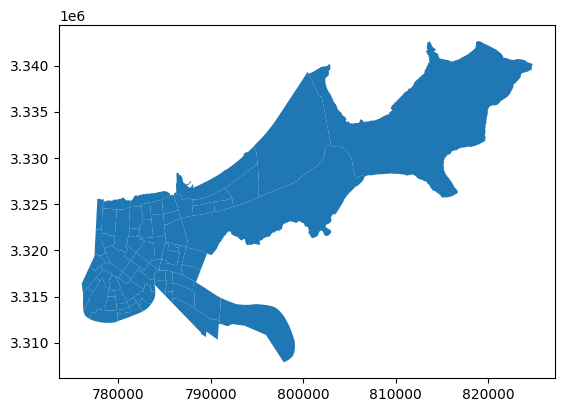

In [7]:
neighborhoodDf.plot()

In [8]:
bounds = [int(b) for b in neighborhoodDf.total_bounds]

In [9]:
xPixels = (bounds[2] - bounds[0]) / resolution
yPixels = (bounds[3] - bounds[1]) / resolution
lp(f"Resolution will be {xPixels} x {yPixels}  Runtime based on {xPixels*yPixels}")

[2025-03-30 01:41:32.910688] Resolution will be 4880.7 x 3475.8  Runtime based on 16964337.06


In [10]:
startTime = datetime.now()
boxes = [shapely.box(x,y,x+resolution,y+resolution) for x, y in product(range(bounds[0], bounds[2], resolution), range(bounds[1], bounds[3], resolution))]
boxesDf = gpd.GeoDataFrame(geometry=boxes).set_crs(neighborhoodDf.crs)
boxesDf = boxesDf[boxesDf.intersects(neighborhoodDf.union_all())].copy()
boxesDf['AltitudeTotal'] = np.nan
boxesDf['WaterTotal'] = np.nan
boxesDf['Int'] = np.nan
boxesDf['Total'] = np.nan
boxesDf['RunTime'] = datetime.now()-datetime.now()
lp(f"boxesDf shape {boxesDf.shape}")
lp(f"Time to generate boxes {datetime.now()-startTime}")

lp(f"Writing to {outFileName}")
boxesDf.to_parquet(outFileName)

[2025-03-30 02:46:59.670616] boxesDf shape (5394495, 6)
[2025-03-30 02:46:59.670725] Time to generate boxes 1:05:26.754350
[2025-03-30 02:46:59.670762] Writing to ./output/boxesDf_10m.parquet


In [11]:
lp(f"Size of boxesDf:  {round(sys.getsizeof(boxesDf)/1E10)}MB")

[2025-03-30 02:47:05.620567] Size of boxesDf:  0MB


In [16]:
sizeOfOutObj = boxesDf.shape[0] * sys.getsizeof( np.array((0,0,0,0,timedelta()))) /1E10
lp(f"Estiated size of output obj {round(sizeOfOutObj)}MB")

[2025-03-30 08:59:50.821703] Estiated size of output obj 0MB


[2025-03-30 02:47:05.628638] Plotting


<Axes: >

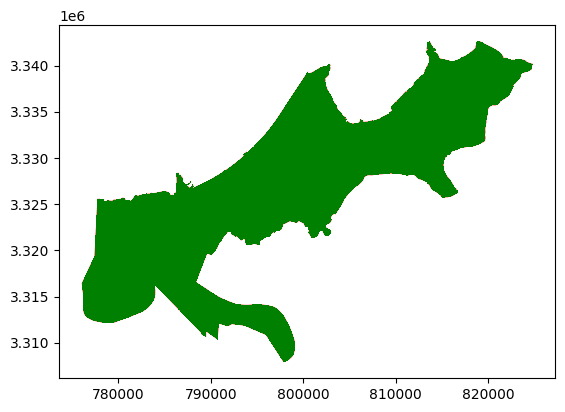

In [13]:
lp("Plotting")
ax = neighborhoodDf.plot(color='red')
boxesDf.plot(ax=ax, color='green')

In [14]:
lp(f"Done created {resolution}m")

[2025-03-30 02:56:20.954554] Done created 10m


In [15]:
!aws s3 cp $outFileName s3://requesterpays.garyscorner.net/datasets/NewOrleansElevation/

upload: output/boxesDf_10m.parquet to s3://requesterpays.garyscorner.net/datasets/NewOrleansElevation/boxesDf_10m.parquet
